<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_12_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 12 - R

## 1. Estimation of Mean Squared Error

In [1]:
#' est.MSE() - Esitmate MSE 
#' @param reps - Number of repetitions to get MSE
#' @param sample_size - Sample size per simulation
#' @param true_par - True parameter
#' @param simulator - Function to simulate data
#' @param estimator - Function to estimate parameter from data 
#' @return - Mean squared error
est.MSE <- function(reps,sample_size,true_par,simulator,estimator,...){
    MSE <- rep(0,length=reps)
    for(i in 1:reps){               ## repeat [reps] times
      dat <- simulator(sample_size,true_par)  ## simulate data
      est_par <- estimator(dat,...) ## ... allows other parameters
      MSE[i] <- mean((est_par-true_par)^2)
    }
    return(mean(MSE))
}

In [2]:
#' trimmed estimator of mean
#' @param x - data
#' @param k - Number of outliers to remove
#' @return Trimmed estimate of mean removing 2k extreme samples
trim.mean <- function(x,k=5){
  x <- sort(x)
  return(mean(x[(k+1):(length(x)-k)]))
}

In [3]:
# Example 1 - normal distribution
set.seed(1000)  # for reproducibility
MSE_0 <- est.MSE(reps=100000,sample_size=20,true_par=0,
                 simulator=rnorm,estimator=trim.mean,k = 0)
MSE_1 <- est.MSE(reps=100000,sample_size=20,true_par=0,
                 simulator=rnorm,estimator=trim.mean,k = 5)
print(MSE_0) # regular sample mean
print(MSE_1) # trimed mean with k  = 5

[1] 0.04972787
[1] 0.05949043


In [4]:
#' rmixnorm() ~ (1-p)N(mu,var0) + pN(0,var1)
#' @param n - number of random samples
#' @param mu - the intended mean
#' @param prob - proportion of non-outliers
#' @return Simulated random values
rmixnorm <- function(n,mu=0,var0=1,var1=1000,prob=0.9){
  idx <- which(runif(n) < prob)
  r <- rep(NA,length=n)
  r[idx] <- rnorm(length(idx),mean=mu,sd=sqrt(var0))    ## N(mu,var0)
  r[-idx] <- rnorm(n-length(idx),mean=mu,sd=sqrt(var1)) ## N(mu,var1)
  return(r)
}

In [5]:
# Example 2 - Mixture of normal
set.seed(1000)  # for reproducibility
MSE <- rep(NA,length=10)
for(k in 1:10){
  MSE[k] <- est.MSE(reps=10000,sample_size=20,true_par=0,
                 simulator=rmixnorm,estimator=trim.mean,k=k-1)
}
names(MSE) = paste("k =",0:9)
print(MSE)

     k = 0      k = 1      k = 2      k = 3      k = 4      k = 5      k = 6 
5.05832839 1.37663759 0.32167508 0.12135894 0.08156617 0.07774524 0.07953943 
     k = 7      k = 8      k = 9 
0.08515286 0.09048951 0.09318956 


## 2. Estimation of Confidence Level

In [6]:
#' est.CL() - Esitmate Confidence Level
#' @param reps - Number of repetitions to get CL
#' @param sample_size - Sample size per simulation
#' @param true_par - True parameter
#' @param simulator - Function to simulate data
#' @param create.CI - Function to estimate confidence interval as vector of size 2 
#' @return - Mean estimator of confidence level
est.CL <- function(reps,sample_size,true_par,simulator,create.CI,...){
  CL <- rep(0,length=reps)  
  for(i in 1:reps){
    dat <- simulator(sample_size,true_par) ## simulate the data
    CI <- create.CI(dat,...)  ## create confidence interval
    ## calculate confidence level
    CL[i] <- as.numeric((CI[1] <= true_par) & (true_par <= CI[2])) 
  }
  return(mean(CL))
}

In [7]:
#' var.CI() - one-sided CI estimator
#' @param x - observed data
#' @param alpha - rejection probability under the null
#' @return A vector with (lower=0, upper) confidence interval
var.CI <- function(x,alpha=0.05){
  n <- length(x)
  U <- (n-1) * var(x) / qchisq(alpha, df=n-1)
  L <- 0
  return(c(L=L,U=U)) 
}

In [8]:
# N(0,1)
CL_1 <- est.CL(reps=50000,sample_size=200,
               true_par=1,
               simulator=function(x,s) rnorm(x,sd=sqrt(s)),
               create.CI=var.CI)
print(CL_1,digits=8)

[1] 0.95018


In [9]:
# N(0,5)
CL_2 <- est.CL(reps=50000,sample_size=200,
               true_par=5,
               simulator=function(x,s) rnorm(x,sd=sqrt(s)),
               create.CI=var.CI)
print(CL_2,digits=8)

[1] 0.95176


In [10]:
# 0.9*N(0,1) + 0.1*N(0,1000)
CL_3 <- est.CL(reps=50000,sample_size=200,
               true_par=1,
               simulator=function(x,s) rmixnorm(x,var0=s),
               create.CI=var.CI)
print(CL_3,digits=8)

[1] 1


## 3. Type I error and power

In [11]:
#' rej.prob() - Estimate Type I error and Power
#' @param reps - Number of repetitions to get power/type I error
#' @param sample_size - Sample size per simulation
#' @param true_par - True parameter
#' @param simulator - Function to simulate data
#' @param test.fun - Function to test the null hypothesis 
#' @return - Power/Type I Error estimates
rej.prob <- function(reps,sample_size,true_par,simulator,test.fun,...){
  phi = rep(NA,length=reps)
  for(j in 1:reps){
    dat <- simulator(sample_size,true_par)
    phi[j] <- test.fun(dat,...) 
  }
  return(mean(phi))
}

In [12]:
#' t.test.fun() - 1-side t-test with H1: mu>mu0
#' @param x - Observed data
#' @param mu0 - null parameter
#' @param alpha - Type I error rate
#' @return Logical vector to test accept/reject of H0
t.test.fun <- function(x,mu0=500,alpha=0.05){
  n <- length(x)
  T.stat <- sqrt(n)*(mean(x)-mu0)/sd(x)
  return(T.stat > qt(1-alpha,df=n-1))
}

In [13]:
typeIerr = rej.prob(reps=50000,sample_size=20,true_par=500,simulator=rnorm,
                     test.fun = t.test.fun)
print(typeIerr)

[1] 0.04988


In [14]:
power = rej.prob(reps=50000,sample_size=20,true_par=500.5,simulator=rnorm,
                     test.fun = t.test.fun)
print(power)

[1] 0.69734


In [15]:
mu_list = seq(500,502,length=50)
power_curve <- sapply(mu_list,function(theta) 
  rej.prob(reps=10000,sample_size=20,true_par=theta,simulator=rnorm,
           test.fun = t.test.fun))

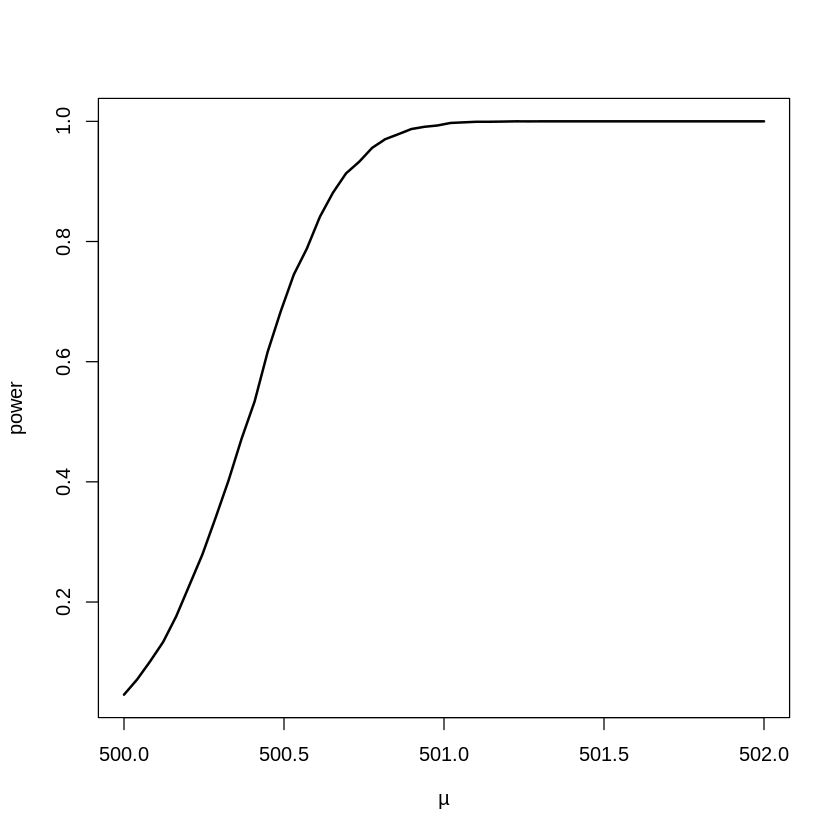

In [16]:
plot(mu_list,power_curve,type="l",lwd=2,
     xlab=expression(mu),ylab="power")